# 흉부 X-ray 이미지로 정상/코로나/폐렴을 분류하는 프로젝트


url : https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset?resource=download

train (normals : 70, covids : 111, pneumonias : 70)

test (normals : 20, covids : 26, pneumonias : 20)

# 1. 이미지 파일 경로 불러오기

In [150]:
import os

In [151]:
IMAGE_FORMAT = ["jpeg", "jpg", "png"]

def list_image_files(data_dir, sub_dir):
    image_files = []
    images_dir = os.path.join(data_dir, sub_dir)
    for file_path in os.listdir(images_dir):
        if file_path.split(".")[-1] in IMAGE_FORMAT:
            image_files.append(os.path.join(sub_dir, file_path))
    
    return image_files

In [152]:
data_dir = "./Covid19-dataset/train/"

normals_list = list_image_files(data_dir, "Normal")
covids_list = list_image_files(data_dir, "Covid")
pneumonias_list = list_image_files(data_dir, "Viral Pneumonia")


In [153]:
print(len(normals_list), len(covids_list), len(pneumonias_list))

70 111 70


In [154]:
data_dir + normals_list[0]

'./Covid19-dataset/train/Normal\\01.jpeg'

# 2. 이미지파일을 RGB 3차원 배열로 불러오기

In [155]:
import cv2

In [156]:
def get_RGB_image(data_dir, file_name):
    image_file = os.path.join(data_dir, file_name)
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# 3. 이미지데이터 확인하기

In [157]:
import matplotlib.pyplot as plt
from ipywidgets import interact

In [158]:
# 제일 작은 파일을 가진 폴더를 기준으로 스크롤 바를 제작
min_num_files = min(len(normals_list), len(covids_list), len(pneumonias_list))
print(min_num_files)

70


In [159]:
# 이미지 데이터를 보면서 인사이트 찾기
# 데이터마다 사이즈가 다름을 확인 --> resize를 해주어야 함
@interact(index=(0, min_num_files-1))
def show_samples(index=0):
    normal_image = get_RGB_image(data_dir, normals_list[index])
    covid_image = get_RGB_image(data_dir, covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, pneumonias_list[index])
    
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.title("Normal")
    plt.imshow(normal_image)
    
    plt.subplot(132)
    plt.title("Covid")
    plt.imshow(covid_image)
    
    plt.subplot(133)
    plt.title("Pneumonia")
    plt.imshow(pneumonia_image)

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

# 4. 학습데이터셋 클래스 구축

In [160]:
train_data_dir = "./Covid19-dataset/train/"
class_list = ["Normal", "Covid", "Viral Pneumonia"]

In [299]:
class Chest_dataset():
    def __init__(self, data_dir, transformer=None):
        self.data_dir = data_dir
        normals = list_image_files(data_dir, "Normal")
        covids = list_image_files(data_dir, "Covid")
        pneumonias = list_image_files(data_dir, "Viral Pneumonia")
        
        self.files_path = normals + covids + pneumonias
        self.transformer = transformer
    
    
    def __len__(self):
        return len(self.files_path)
    
    
    def __getitem__(self, index):
        image_file = os.path.join(self.data_dir, self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        class_name = self.files_path[index].split(os.sep)[0]
        class_id = class_list.index(class_name)
        
        if self.transformer:
            image = self.transformer(image)
            class_id = torch.Tensor([class_id]).long()
            
        return image, class_id

In [300]:
dset = Chest_dataset(data_dir=train_data_dir)

In [301]:
image, class_id = dset[100]

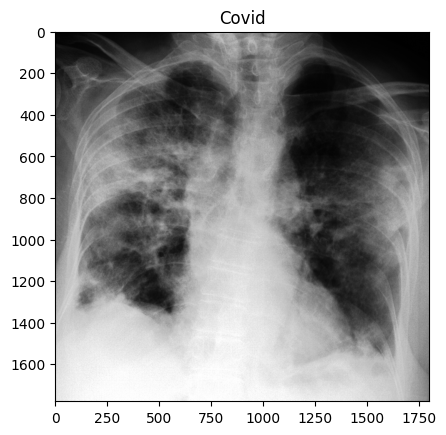

In [302]:
index = 100
image, target = dset[index]


plt.title(class_list[target])
plt.imshow(image)

In [303]:
print(image.shape)

(1779, 1800, 3)


# 5. 연산가능한 텐서형으로 데이터 변환하기 

In [304]:
import torch
from torchvision import transforms

In [305]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

In [311]:
index = 200
dset = Chest_dataset(data_dir=train_data_dir)
image = dset[index][0]
target = dset[index][1]
print(image.shape)
print(target)

(1024, 1336, 3)
2


In [312]:
train_dset = Chest_dataset(train_data_dir, transformer)
index = 200
image = train_dset[index][0]
target = train_dset[index][1]
print(image.shape)
print(target)

torch.Size([3, 224, 224])
tensor([2])


#  6. 데이터 로더 구현하기

In [313]:
from torch.utils.data import DataLoader

In [314]:
train_data_dir = "./Covid19-dataset/train/"
val_data_dir = "./Covid19-dataset/test/"

train_dset = Chest_dataset(train_data_dir, transformer)
train_dloader = DataLoader(train_dset, batch_size=4, shuffle=True, drop_last=True)

val_dset = Chest_dataset(val_data_dir, transformer)
val_dloader = DataLoader(val_dset, batch_size=1, shuffle=False)



In [315]:
def build_dataloader(train_data_dir, val_data_dir):
    dataloaders = {}
    train_dset = Chest_dataset(train_data_dir, transformer)
    dataloaders["train"] = DataLoader(train_dset, batch_size=4, shuffle=True, drop_last=True)

    val_dset = Chest_dataset(val_data_dir, transformer)
    dataloaders["val"] = DataLoader(val_dset, batch_size=1, shuffle=False)
    return dataloaders

In [316]:
dataloaders = build_dataloader(train_data_dir, val_data_dir)

In [317]:
# 원래 데이터셋 / batch_size
len(dataloaders["train"])

62

#  7. Claasification 모델(VGG19) 불러오기

In [318]:
from torchvision import models

In [319]:
model = models.vgg19(pretrained=True)

C:\Users\tfg00\anaconda3\envs\fastcampus\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\tfg00\anaconda3\envs\fastcampus\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [320]:
from torchsummary import summary

summary(model, (3, 224, 224), batch_size=1, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

# 8. 데이터에 맞도록 모델 Head 부분 변경하기

In [321]:
import torch.nn as nn

In [322]:
# 어떠한 크기의 input 값이 들어와도 avgpool2d에서의 출력크기를 (1,1)로 저장 -> Adaptive의 특징
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
model.avgpool

AdaptiveAvgPool2d(output_size=(1, 1))

In [323]:
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 3),
    nn.Sigmoid(),
)

In [324]:
def build_vgg19_based_model(device="cpu"):
    device = torch.device(device)
    model = models.vgg19(pretrained=True)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 256),
        nn.ReLU(),
        # nn.Dropout(0.1),
        nn.Linear(256, 3),
        # nn.Sigmoid(),
        nn.Softmax(dim=1)
    )
    return model.to(device)

In [325]:
model = build_vgg19_based_model(device="cpu")

In [326]:
summary(model, (3, 224, 224), batch_size=1, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

# 9. 손실함수(Cross-Entropy) 불러오기

In [327]:
loss_func = nn.CrossEntropyLoss(reduction="mean") # Crossentropy 함수 사용

# 10. SGDM 최적화 기법 적용하기 
- Stochastic Gradient Descent with Momentum(SGDM) Optimization

In [328]:
# 파라미터, 러닝레이트
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 

# 11. 모델 학습을 위한 함수 구현하기

In [329]:
device = torch.device("cpu")

In [330]:
def train_one_epoch(dataloaders, model, optimizer, loss_function, device):
    loss = {}
    
    for phase in ["train", "val"]: # train, validation 두 가지 배열 생성
        running_loss = 0.0
        
        if phase == "train": # 훈련 모드
            model.train()
        else:
            model.eval() # validation 모드
            
        for index, batch in enumerate(dataloaders[phase]): # 데이터로더에서 phase(train, val)에 해당하는 데이터 가져옴
            image = batch[0].to(device) # 이미지
            label = batch[1].to(device) # 라벨
            
            with torch.set_grad_enabled(phase == "train"): # train일 경우 gradient descent를 진행, 자원을 획득한 후에 반납함
                prediction = model(image) # 이미지로 예측
                loss = loss_func(prediction, label) # loss 값 계산
                
                if pahse == "train":
                    optimizer.zero_grad() # gradient 초기화
                    loss.backward() # 오차 역전파 진행, 그 전 스텝의 값에 영향을 받지 않기 위해 zero_grad() 후에 진행
                    optimizer.step() # learning_rate 값을 토대로 모델의 weight 값을 갱신함
                
            running_loss += loss.item()
            
            if phase == "train":
                if index % 10 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
                    
        losses[phase] = running_loss / len(dataloaders[phase])
    return losses

# 12. 모델 검증을 위한 Accuracy 생성하기
- Top-1 accuracy
    - 가장 confidence가 높은 예측값의 클래스가 ground truth와 일치하는 경우 True-Positive로 판단
- Top-5 accuracy
    - confidence가 높은 상위 5개 예측값의 클래스에 ground truth가 존재하는 경우 True-Positive로 판단

In [352]:
@torch.no_grad()
def get_accuracy(image, target, model):
    batch_size = image.shape[0]
    prediction = model(image) # (B, NUM_CLASSES) - [B, 0] : 0.8, [B, 1] : 0.1, [B, 2] : 0.1
    _, pred_label = torch.max(prediction, dim=1) # (B, 1) -> pred_label:0
    is_correct = (pred_label == target) # True/False
    accuracy = is_correct.cpu().numpy().sum() / batch_size # True인 것들만 더해 batch로 나눔
    return accuracy

In [353]:
def train_one_epoch(dataloader, model, optimizer, loss_function, device):
    loss = {}
    accuracies = {}
    
    for phase in ["train", "val"]: # train, validation 두 가지 배열 생성
        running_loss = 0.0
        running_correct = 0.0
        
        if phase == "train": # 훈련 모드
            model.train()
        else:
            model.eval() # validation 모드
            
        for index, batch in enumerate(dataloader[phase]): # 데이터로더에서 phase(train, val)에 해당하는 데이터 가져옴
            image = batch[0].to(device) # 이미지
            label = batch[1].squeeze(dim=1).to(device) # 라벨
            
            with torch.set_grad_enabled(phase == "train"): # train일 경우 gradient descent를 진행, 자원을 획득한 후에 반납함
                prediction = model(image) # 이미지로 예측
                loss = loss_func(prediction, label) # loss 값 계산
                
                if pahse == "train":
                    optimizer.zero_grad() # gradient 초기화
                    loss.backward() # 오차 역전파 진행, 그 전 스텝의 값에 영향을 받지 않기 위해 zero_grad() 후에 진행
                    optimizer.step() # learning_rate 값을 토대로 모델의 weight 값을 갱신함
                
            running_loss += loss.item()
            running_correct += get_accuracy(image, label, model)
            
            if phase == "train":
                if index % 10 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
                    
        losses[phase] = running_loss / len(dataloader[phase])
        accuracies[phase] = running_correct / len(dataloader[phase])
        
    return losses, accuracies

In [354]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data_dir = "./Covid19-dataset/train/"
val_data_dir = "./Covid19-dataset/test/"
dataloaders = build_dataloader(train_data_dir, val_data_dir)
model = build_vgg19_based_model(device='cuda')
loss_func = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [355]:
def train_one_epoch(dataloader, model, optimizer, loss_function, device):
    losses = {}
    accuracies = {}
    
    for phase in ["train", "val"]: # train, validation 두 가지 배열 생성
        running_loss = 0.0
        running_correct = 0.0
        
        if phase == "train": # 훈련 모드
            model.train()
        else:
            model.eval() # validation 모드
            
        for index, batch in enumerate(dataloader[phase]): # 데이터로더에서 phase(train, val)에 해당하는 데이터 가져옴
            image = batch[0].to(device) # 이미지
            label = batch[1].squeeze(dim=1).to(device) # 라벨
            
            with torch.set_grad_enabled(phase == "train"): # train일 경우 gradient descent를 진행, 자원을 획득한 후에 반납함
                prediction = model(image) # 이미지로 예측
                loss = loss_func(prediction, label) # loss 값 계산
                
                optimizer.zero_grad() # gradient 초기화
                          
                if phase == "train":
                    loss.backward() # 오차 역전파 진행, 그 전 스텝의 값에 영향을 받지 않기 위해 zero_grad() 후에 진행
                    optimizer.step() # learning_rate 값을 토대로 모델의 weight 값을 갱신함
                
            running_loss += loss.item()
            running_correct += get_accuracy(image, label, model)
            
            if phase == "train":
                if index % 10 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
                    
        losses[phase] = running_loss / len(dataloader[phase])
        accuracies[phase] = running_correct / len(dataloader[phase])
        
    return losses, accuracies

In [356]:
num_epochs = 10

best_acc = 0.0
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for epoch in range(num_epochs):
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    train_loss.append(losses['train'])
    train_acc.append(accuracies['train'])
    val_loss.append(losses['val'])
    val_acc.append(accuracies['val'])
    
    print(f"{epoch}/{num_epochs}-Tr loss:{losses['train']}, Val loss: {losses['val']}")
    print(f"{epoch}/{num_epochs}-Tr acc:{accuracies['train']}, Val acc: {accuracies['val']}")
    
    if accuracies['val'] > best_acc:
        best_acc = accuracies['val']
        torch.save(model.state_dict(), f"model_{epoch}.pth")

0/62 - Running loss: 1.0923619270324707
10/62 - Running loss: 1.096632480621338
20/62 - Running loss: 1.0843851566314697
30/62 - Running loss: 1.0522525310516357
40/62 - Running loss: 0.9545024633407593
50/62 - Running loss: 0.9302485585212708
60/62 - Running loss: 1.0134353637695312
0/10-Tr loss:1.0496047975555542, Val loss: 0.9698686283646207
0/10-Tr acc:0.46774193548387094, Val acc: 0.6363636363636364
0/62 - Running loss: 0.9872382879257202
10/62 - Running loss: 0.8142650723457336
20/62 - Running loss: 0.8883548974990845
30/62 - Running loss: 1.0267999172210693
40/62 - Running loss: 0.6467283368110657
50/62 - Running loss: 0.8336772322654724
60/62 - Running loss: 0.680501401424408
1/10-Tr loss:0.8462305578493303, Val loss: 0.9543008280522896
1/10-Tr acc:0.7298387096774194, Val acc: 0.5151515151515151
0/62 - Running loss: 0.9821743369102478
10/62 - Running loss: 0.9189497232437134
20/62 - Running loss: 0.7917211651802063
30/62 - Running loss: 0.9868414998054504
40/62 - Running loss: 

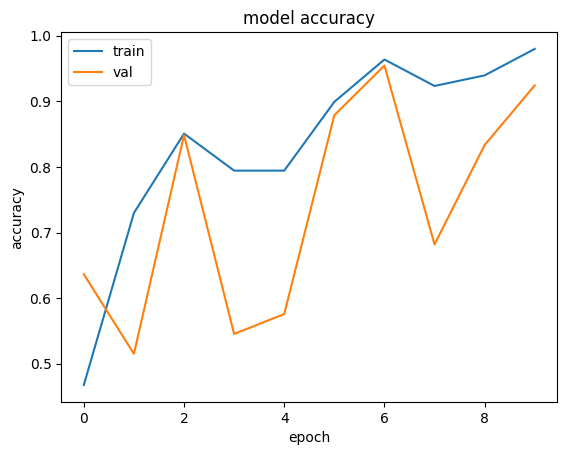

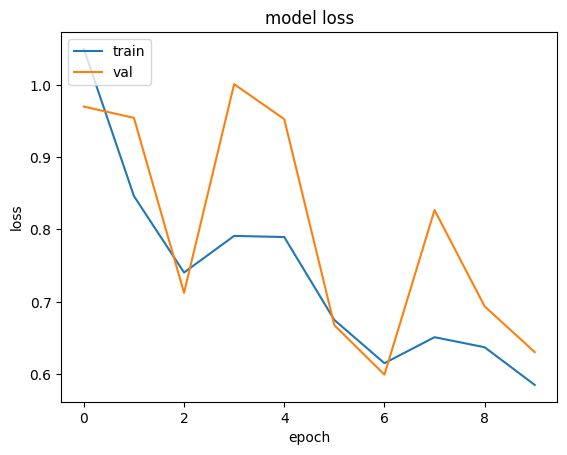

In [358]:
# model accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# model loss loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 14. 테스트 이미지를 통한 학습모델 분류성능 검증하기

In [359]:
data_dir = "./Covid19-dataset/test/"
class_list = ["Normal", "Covid", "Viral Pneumonia"]

test_normals_list = list_image_files(data_dir, "Normal")
test_covids_list = list_image_files(data_dir, "Covid")
test_pneumonias_list = list_image_files(data_dir, "Viral Pneumonia")

In [360]:
len(test_normals_list), len(test_covids_list),len(test_pneumonias_list)

(20, 26, 20)

In [361]:
def preprocess_image(image):
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ])
    
    tensor_image = transformer(image) # (C, H, W) 
    tensor_image = tensor_image.unsqueeze(dim=0) # (B, C, H, W) 배치 형태의 이미지를 만듦
    
    return tensor_image

In [362]:
@torch.no_grad()
def model_predict(image, model):
    tensor_image = preprocess_image(image)
    prediction = model(tensor_image)
    _, pred_label = torch.max(prediction.detach().cpu(), dim=1) # (B, NUM_CLASSES) # 가장 confidence score가 높은 것을 가졍모
    pred_label = pred_label.squeeze(dim=0) # 더미 배치 포맷 제거
    return pred_label

In [364]:
ckpt = torch.load("./model_6.pth")

In [365]:
model = build_vgg19_based_model(device='cpu')
model.load_state_dict(ckpt)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [366]:
min_num_files = min(len(test_normals_list), len(test_covids_list), len(test_pneumonias_list))

# GT : Ground Truth AI 훈련 모델의 출력값을 테스트 하는데 사용한 실제 환경의 데이터
@interact(index=(0, min_num_files-1))
def show_result(index=0):
    normal_image = get_RGB_image(data_dir, test_normals_list[index])
    covid_image = get_RGB_image(data_dir, test_covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, test_pneumonias_list[index])
    
    pred_normal = model_predict(normal_image, model)
    pred_covid = model_predict(covid_image, model)
    pred_pneumonia = model_predict(pneumonia_image, model)
    
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.title(f"Pred:{class_list[pred_normal]} | GT:Normal")
    plt.imshow(normal_image)
    
    plt.subplot(132)
    plt.title(f"Pred:{class_list[pred_covid]} | GT:Covid")
    plt.imshow(covid_image)
    
    plt.subplot(133)
    plt.title(f"Pred:{class_list[pred_pneumonia]} | GT:Viral Pneumonia")
    plt.imshow(pneumonia_image)

interactive(children=(IntSlider(value=0, description='index', max=19), Output()), _dom_classes=('widget-intera…

# 정리
1. 이미지 데이터셋 구축
- train, validation을 dictonary 형태의 dataloader로 작성할 경우 유용하게 사용할 수 있음
   
2. Torchvision transforms 라이브러리를 이용해 텐서형 데이터로 변환(모델 연산을 위해)
   
   transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ])


3. Pretrained VGG19 모델을 불러와 Head 부분을 수정
- model.avgpool = nn.AdaptiveAvgPool2d(outputsize=(1,1)) # 어떠한 형태의 데이터가 들어와도 outputsize를 1,1로 풀링을 진행함

4. Cross Entropy Loss function을 적용
- Cross Entropy 값을 계산 후 Loss 값을 최소화 시키는 방향으로 진행
- loss_func = nn.CrossEntropyLoss(reduction="mean") # Crossentropy 함수 

5. SGDM 최적화기법 이해 및 적용
- optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 
- 확률적 경사하강법을 통해 모델의 일반화 성능을 높힘

6. 인간 추론원리와 닮은 딥러닝 결과의 이해